In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('bank_transactions.csv')

df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%y', errors='coerce')

df = df.dropna()

df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors='coerce')
df['CustomerAge'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365

df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,30.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,-33.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,27.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,51.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,36.0


In [6]:
df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].astype(float)

customer_summary = df.groupby('CustomerID').agg(
    avg_balance=('CustAccountBalance', 'mean'),
    avg_transaction_amount=('TransactionAmount (INR)', 'mean'),
    transaction_frequency=('TransactionID', 'count')
).reset_index()

customer_summary.head()

,CustomerID,avg_balance,avg_transaction_amount,transaction_frequency
0,C1010011,76340.635,2553.0,2
1,C1010012,24204.490,1499.0,1
2,C1010014,100112.950,727.5,2
3,C1010018,496.180,30.0,1
4,C1010024,87058.650,5000.0,1


In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary[['avg_balance', 'avg_transaction_amount', 'transaction_frequency']])

scaled_features[:5]

array([[-0.04790311,  0.15329836,  1.81640799],
       [-0.11298516, -0.0105381 , -0.41099187],
       [-0.0182279 , -0.13046204,  1.81640799],
       [-0.14258047, -0.23888323, -0.41099187],
       [-0.03452371,  0.53366632, -0.41099187]])

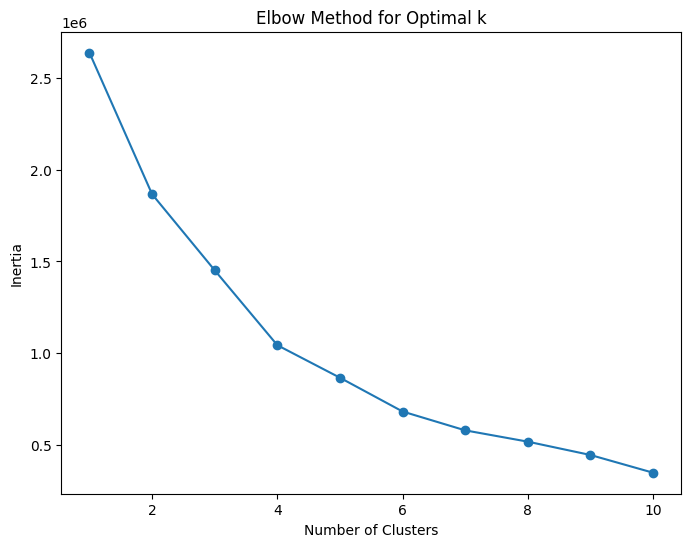

In [8]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Cluster Centers:
 [[-1.79793700e-02 -4.72138668e-02 -4.10991874e-01]
 [-9.46602277e-03 -2.33430991e-02  2.13551399e+00]
 [ 4.21434396e-01  1.03662648e+01 -1.72911668e-01]
 [ 3.32564088e+01  8.18236031e-01 -9.76747575e-02]]


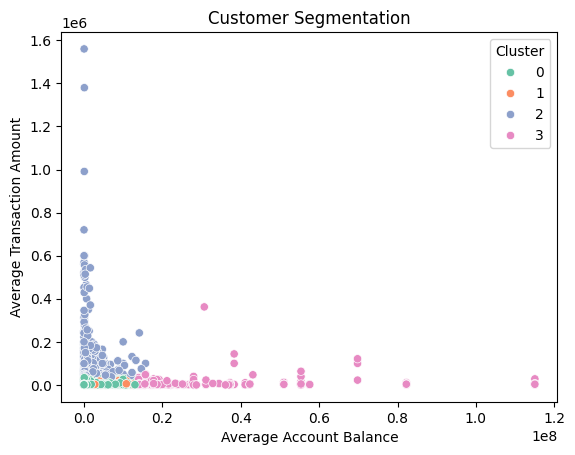

In [11]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

customer_summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

sns.scatterplot(x='avg_balance', y='avg_transaction_amount', hue='Cluster', data=customer_summary, palette='Set2')
plt.title('Customer Segmentation')
plt.xlabel('Average Account Balance')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Cluster')
plt.show()


In [12]:
cluster_summary = customer_summary.groupby('Cluster').agg(
    avg_balance=('avg_balance', 'mean'),
    avg_transaction_amount=('avg_transaction_amount', 'mean'),
    transaction_frequency=('transaction_frequency', 'mean')
).reset_index()

print("Cluster Characteristics:\n", cluster_summary)

Cluster Characteristics:
    Cluster   avg_balance  avg_transaction_amount  transaction_frequency
0        0  1.003122e+05             1263.101523               1.000000
1        1  1.071319e+05             1416.622301               2.143264
2        2  4.523870e+05            68264.727585               1.106917
3        3  2.675587e+07             6830.706488               1.140665
